In [1]:
import metpy.calc as mpcalc
from metpy.constants import g, Cp_d, Lv, Rd, omega
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units, concatenate
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## These functions are PR's for MetPy already

In [2]:
def dry_static_energy(heights, temperature):
    r"""Calculate the dry static energy of parcels.

    This function will calculate the dry static energy following the first two terms of
    equation 3.72 in [REF.

    Notes
    -----
    .. math::\text{dry static energy} = c_{pd} * T + gz

    * :math:`T` is temperature
    * :math:`z` is height

    Parameters
    ----------
    heights : array-like
        Atmospheric height profile
    temperature : array-like
        Atmospheric temperature profile

    Returns
    -------
    `pint.Quantity`
        The dry static energy.

    """

    return (g * heights + Cp_d * temperature).to('kJ/kg')


def moist_static_energy(heights, temperature, specific_humidity):
    r"""Calculate the moist static energy of parcels.

    This function will calculate the moist static energy following equation 3.72 in [REF.

    Notes
    -----
    .. math::\text{moist static energy} = c_{pd} * T + gz + L_v q

    * :math:`T` is temperature
    * :math:`z` is height
    * :math:`q` is specific humidity

    Parameters
    ----------
    heights : array-like
        Atmospheric height profile
    temperature : array-like
        Atmospheric temperature profile
    specific_humidity : array-like
        Atmospheric specific humidity profile

    Returns
    -------
    `pint.Quantity`
        The moist static energy.

    """

    return (dry_static_energy(heights, temperature) + Lv * specific_humidity).to('kJ/kg')


def specific_humidity_from_mixing_ratio(mixing_ratio):
    r"""Calculate the specific humidity from the mixing ratio.

    Parameters
    ----------
    mixing_ratio: `pint.Quantity`
        mixing ratio

    Returns
    -------
    `pint.Quantity`
        Specific humidity

    Notes
    -----
    Formula from [Salby1996]_ pg. 118.

    .. math:: q = \frac{w}{1+w}

    * :math:`w` is mixing ratio
    * :math:`q` is the specific humidity

    See Also
    --------
    mixing_ratio

    """
    return mixing_ratio / (1 + mixing_ratio)

## This is the prototype library code

In [3]:
class MassEnergyIsohumes(object):
    """Make isohumes for mass energy plots.
    
    This class makes isohumes and labels for mass energy plots of 
    upper air data.
    
    Attributes
    ----------
    ax : `matplotlib.axes.Axes`
        The underlying Axes instance, which can be used for calling additional
        plot functions (e.g. `axvline`)
        
    """
    
    def __init__(self, ax, pressure, static_dry_energy,
                 saturation_specific_humidity,):
        """Create mass energy plots.
        
        Parameters
        ----------
        ax : `matplotlib.axes.Axes`
            Source axis to use for plotting.
        pressure : array-like
            Atmospheric pressure profile
        isohume_values : array-like
            Isohume values plotted.
        static_dry_energy : array_like
            Values of static dry energy for the data
        saturation_specific_humidity : array_like
            Values of saturation specific humidity for the data
        
        """
        self.ax = ax
        self.pressure = pressure
        self.isohume_values = []
        self.static_dry_energy = static_dry_energy
        self.saturation_specific_humidity = saturation_specific_humidity

    def plot_isohumes(self, values=np.arange(10, 100, 10) * units.percent, **kwargs):
        """Add lines of constant relative humidity.
        
        Plots lines of constant relative humidity as fiducials.
        
        Parameters
        ----------
        values : array_like, optional
            Values of relative humidity to plot
        kwargs
            Other keyword arguments to pass to :func:`~matplotlib.pyplot.plot`
        
        Returns
        -------
        list[matplotlib.lines.Line2D]
            lines plotted
            
        """
        # Default plotting style, updated by any kwargs
        plotting_style = {'linewidth': 0.5, 'linestyle': ':', 'color': 'black'}
        plotting_style.update(kwargs)
        
        lines = []
       
        # Add lines of constant RH
        for rh in values:
            isohume_energy = (self.static_dry_energy + Lv *
                              self.saturation_specific_humidity * rh)
            line = self.ax.plot(isohume_energy, pressure, **plotting_style)
            lines.append(line)
            self.isohume_values.append(rh)
        return lines
    
    def label_isohumes(self, label_y_position=800 * units.hPa, **kwargs):
        """Add lines of constant relative humidity.
        
        Plots lines of constant relative humidity as fiducials.
        
        Parameters
        ----------
        label_y_position: `pint.Quanity`, optional
            Pressure coordinate of relative humidity labels
        kwargs
            Other keyword arguments to pass to :func:`~matplotlib.pyplot.plot`
        
        Returns
        -------
        list[matplotlib.text.Annotation]
            annotations plotted
            
        """
        # Default text style, updated by kwargs
        text_style = {'horizontalalignment': 'center', 'fontsize': 8}
        text_style.update(kwargs)
        
        annotations = []
        
        # Interpolate data (linearly) to be at the label position
        parcel_static_dry_energy = mpcalc.interp(concatenate([label_y_position]), self.pressure, self.static_dry_energy)[0]
        parcel_saturation_specific_humidity = mpcalc.interp(concatenate([label_y_position]), self.pressure, self.saturation_specific_humidity)[0]
        for rh in self.isohume_values:
            label_x_position = (parcel_static_dry_energy + Lv * parcel_saturation_specific_humidity * rh).to('kJ/kg')
            annotation = self.ax.annotate(rh.m, xy=(label_x_position, label_y_position), **text_style)
            annotations.append(annotation)
        return annotations

In [4]:
class MassEnergyPlot(object):
    """Make mass energy plots of data.
    
    This class makes mass energy plots of upper air data and
    the associated marked lines.
    
    Attributes
    ----------
    ax : `matplotlib.axes.Axes`
        The underlying Axes instance, which can be used for calling additional
        plot functions (e.g. `axvline`)
    fig : `matplotlib.figure.Figure`
        The underlying Figure instance to make addition figure manipulation easy
        
    """
    
    def __init__(self, fig=None, ax=None):
        """Create mass energy plots.
        
        Parameters
        ----------
        fig : `matplotlib.figure.Figure`, optional
            Source figure to use for plotting. If none is given, a new
            :class:`matplotlib.figure.Figure` instance will be created.
        ax : `matplotlib.axes.Axes`
            Source axis to use for plotting. If none is given, a new
            :class:`matplotlib.axes.Axes` instance will be created.
        
        """
        # Setup figure and axes if we don't have them
        if fig is None:
            fig = plt.figure(figsize=(11,8))
        if ax is None:
            ax = plt.subplot(1, 1, 1)
        self.fig = fig
        self.ax = ax
        
        # Set default axis limits
        self.ax.set_xlim(250, 400)
        self.ax.set_ylim(1050, 100)

    def isohumes(self, pressure, static_dry_energy, saturation_specific_humidity,
                 values=np.arange(10, 100, 10) * units.percent, 
                 label=True, label_y_position=800 * units.hPa, **kwargs):
        """Add lines of constant relative humidity.
        
        Plots lines of constant relative humidity as fiducials.
        
        Parameters
        ----------
        static_dry_energy : array_like
            Values of static dry energy for the data
        saturation_specific_humidity : array_like
            Values of saturation specific humidity for the data
        values : array_like, optional
            Values of relative humidity to plot
        label : boolean, optional
            Add text indicating the values of relative humidity
        label_y_position: `pint.Quanity`, optional
            Pressure coordinate of relative humidity labels
        kwargs
            Other keyword arguments to pass to :func:`~matplotlib.pyplot.plot`
        
        Returns
        -------
        list[matplotlib.lines.Line2D]
            lines plotted
        list[matplotlib.text.Annotation]
            annotations plotted
            
        """
        isohumes_plotter = MassEnergyIsohumes(self.ax, pressure, static_dry_energy,
                                              saturation_specific_humidity)
        isohumes_plotter.plot_isohumes()
        isohumes_plotter.label_isohumes()
                
    def shade_precipitable_water(self, pressure, moist_static_energy, 
                                 dry_static_energy, **kwargs):
        """Shade area proportional to precipitable water.
        
        Shades the area where the dry static energy of a parcel is greater than the
        moist static energy. This area is proportional to the value of precipitable
        water in the column.
        
        Parameters
        ---------
        pressure : array-like
            Atmospheric pressure profile
        moist_static_energy : array-like
            Atmospheric moist static energy profile
        dry_static_energy : array-like
            Atmospheric dry static energy profile
        kwargs
            Other keyword arguments to pass to :func:`~matplotlib.pyplot.fill_betweenx`
        
        Returns
        -------
        """
        fill_parameters = {'facecolor': 'tab:blue', 'alpha': 0.4}
        fill_parameters.update(kwargs)
        self.ax.fill_betweenx(pressure, moist_static_energy, dry_static_energy,
                              where=dry_static_energy>moist_static_energy, **fill_parameters)

    def rce_reference(self, xloc=260 * units('kJ/kg'),
                      yloc= concatenate([0, 1100] * units.hPa), label=True,
                      text_loc = (260 * units('kJ/kg'), 1045 * units.hPa)):
        """Reference line for radiative convective equilibrium.
        
        Add a reference line for plotting energy reference areas.
        
        Parameters
        ----------
        xloc : `pint.Quantity`, optional
            x-axis location of the reference line
        yloc : array-like, optional
            y-axis values to plot reference line between
        label : boolean,
            plotting of a text label annotation
        text_loc : array-like, optional
            position of the text annotation
            
        Returns
        -------
        matplotlib.lines.Line2D
            line plotted
        matplotlib.text.Annotation
            annotation plotted
            
        """
        annotation = None
        line = self.ax.plot(np.ones((2)) * xloc, yloc, linewidth=0.5)
        if label:
            annotation = self.ax.annotate('Daily RCE', xy=text_loc, horizontalalignment='center')
        return line, annotation
            
    
    def shade_cape(self, pressure, moist_static_energy, saturated_moist_static_energy):
        """Shade the area representing CAPE on a mass energy plot.
        
        Shades the area that represents CAPE on a mass energy plot.
        
        Parameters
        ----------
        pressure : array-like
            Atmospheric pressure profile
        moist_static_energy : array-like
            Atmospheric moist static energy profile
        saturated_moist_static_energy : array-like
            Atmospheric saturated moist static energy profile
            
        Returns
        -------
        matplotlib.collections.PolyCollection
            Shaded region
        """
        parcel_moist_static_energy = moist_static_energy[0]
        self.ax.plot(concatenate([parcel_moist_static_energy, parcel_moist_static_energy]),
                     [np.nanmin(pressure), np.nanmax(pressure)],
                     linewidth=0.5, color='tab:green')
        fill = self.ax.fill_betweenx(pressure, saturated_moist_static_energy,
                                     parcel_moist_static_energy,
                                     where=parcel_moist_static_energy > saturated_moist_static_energy,
                                     facecolor='tab:green', alpha=0.4, interpolate=True)
        return fill
    
    def shade_cin(self, pressure, temperature, dewpoint, virtual_static_dry_energy):
        """Shade the area representing CIN on a mass energy plot.
        
        Shades the area that represents CIN on a mass energy plot.
        
        Parameters
        ----------
        pressure : array-like
            Atmospheric pressure profile
        moist_static_energy : array-like
            Atmospheric moist static energy profile
        saturated_moist_static_energy : array-like
            Atmospheric saturated moist static energy profile
            
        Returns
        -------
        matplotlib.collections.PolyCollection
            Shaded region
        """
        lcl_pressure, _ = mpcalc.lcl(pressure[0], temperature[0], dewpoint[0])
        self.ax.fill_betweenx(pressure, virtual_static_dry_energy, virtual_static_dry_energy[0],
                              where=pressure > lcl_pressure,
                              facecolor='purple', alpha=0.4, interpolate=True)
    
    def shade_flux(self, flux, starting_pressure, starting_energy, depth, 
                   time=1 * units.sidereal_day, alignment='right', **kwargs):
        """Shade an area representing an energy flux.
        
        Shades an area representing a flux (i.e. insolation) over the specified
        period spead over the specified depth.
        
        Parameters
        ----------
        flux : `pint.Quantity`
            Energy flux
        starting_pressure : `pint.Quantity`
            Pressure at which the bottom of the flux area will be drawn
        starting_energy : `pint.Quantity`
            Energy at which the edge of the flux area will be drawn
        depth : `pint.Quantity`
            Pressure depth over which to distribute the flux
        time : `pint.Quantity`, optional
            Time over which flux is distributed
        alignment : string, optional
            Side of `starting_energy` on which to draw the flux area (left or right)
        kwargs : 
            kwargs to pass to `ax.fill`
        
        """
        fill_properties = {'linewidth': 1, 'color': 'orange', 'alpha': 0.5}
        fill_properties.update(kwargs)
        
        width = flux * time * g / depth
        
        if alignment == 'left':
            width = -width
        elif alignment == 'right':
            pass
        else:
            raise ValueError('Unknown option for alignment: {0}'.format(alignment))
        
        x_points = concatenate([starting_energy, starting_energy + width,
                                starting_energy + width, starting_energy])
        y_points = concatenate([starting_pressure, starting_pressure,
                                starting_pressure - depth, starting_pressure - depth])
        self.ax.fill(x_points, y_points, **fill_properties)
    
    def radiative_cooling_reference(self, flux=116 * units('W/m^2'),
                                    starting_pressure=1000 * units.hPa, 
                                    starting_energy=260 * units('kJ/kg'), 
                                    depth=800 * units.hPa, time=1 * units.sidereal_day, 
                                    alignment='left', **kwargs):
        fill_preferences = {'color': 'c'}
        fill_preferences.update(kwargs)
        return self.shade_flux(flux, starting_pressure, starting_energy, depth, time, alignment, **fill_preferences)
    
    def surface_flux_reference(self, flux=116 * units('W/m^2'),
                               starting_pressure=1000 * units.hPa, 
                               starting_energy=260 * units('kJ/kg'), 
                               depth=90 * units.hPa, time=1 * units.sidereal_day, 
                               alignment='right', **kwargs):
        fill_preferences = {}
        fill_preferences.update(kwargs)
        return self.shade_flux(flux, starting_pressure, starting_energy, depth, time, alignment, **fill_preferences)
    
    def internal_waves(self, pressure, temperature, amplitude=100 * units.m, levels=np.arange(900, 100, -100) * units.hPa):
        for level in levels:
            # index of nearest datapoint
            idx = np.argmin(np.abs(pressure - level))
            
            # Calculate temperature change when parcel is displaced
            temperature_change = (-g / Cp_d * amplitude).to('delta_degC')
            wave_temperature = concatenate([temperature[idx] + temperature_change,
                                            temperature[idx] - temperature_change])
            
            # Calculate pressure change over the parcel displacement
            #rho = (-g * pressure[idx] / (Rd  * temperature[idx])).to('kg/m^3')
            pressure_change = ((-pressure[idx] * g) / (Rd * temperature[idx])) * amplitude
            pressure_change = pressure_change.to('hPa')
            wave_pressure = concatenate([pressure[idx] + pressure_change,
                                         pressure[idx] - pressure_change])
            
            # Calculate the change in saturation mixing ratio
            #TODO: Update to actual specific humidity
            wave_specific_humidity = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(wave_temperature) ,wave_pressure)
            #wave_specific_humidity = q[idx] + specific_humidity_change
            
            # Calculate moist static energy
            wave_heights = concatenate([heights[idx] + amplitude,
                                       heights[idx] - amplitude])
            wave_moist_static_energy = moist_static_energy(wave_heights, wave_temperature, wave_specific_humidity)

            
            # Plot wave annotations
            self.ax.plot(wave_moist_static_energy, wave_pressure, linewidth=3, color='tab:red')
            self.ax.plot(concatenate([s[idx], s[idx]]), wave_pressure, linewidth=3, color='tab:red')
            self.ax.plot(concatenate([h[idx], h[idx]]), wave_pressure, linewidth=3, color='tab:blue')
            
    def surface_water_values(self, surface_pressure, surface_height,
                             surface_temperature, surface_specific_humidity, 
                             delta_temperature=np.arange(-2, 5, 2) * units.delta_degC):
        """
        
        Surface water values at 1C intervals, for eyeballing surface fluxes
        """
        surface_temperature = round(surface_temperature)
        
        for dT in delta_temperature:
            calc_temperature = surface_temperature + dT
            #TODO: Update to actual specific humidity
            calc_specific_humidity = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(calc_temperature), surface_pressure)
            surface_dry_static_energy = dry_static_energy(surface_height, calc_temperature)
            surface_moist_static_energy = moist_static_energy(surface_height, calc_temperature,
                                                              calc_specific_humidity)

            self.ax.annotate('{:.0f}'.format(calc_temperature.m), xy=(surface_dry_static_energy, surface_pressure),
                             verticalalignment='top', horizontalalignment='center',
                             color='tab:red', fontsize=7)
            self.ax.annotate('{:.0f}'.format(calc_temperature.m), xy=(surface_moist_static_energy, surface_pressure),
                             verticalalignment='top', horizontalalignment='center',
                             color='tab:red', fontsize=7)
            

## User's Code
This is the code the user would have in their notebook with the current implementation:

In [5]:
date = datetime(2002, 11, 11, 0)
station = 'BNA'

df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values * units(df.units['pressure'])
temperature = df['temperature'].values * units(df.units['temperature'])
dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])
heights = df['height'].values * units(df.units['height'])

#TODO: Update to actual specific humidity
# Calculate mixing ratios
q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(dewpoint), pressure)
qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(temperature), pressure)

# Calculate variables to plot
s = dry_static_energy(heights, temperature)
sv = dry_static_energy(heights, mpcalc.virtual_temperature(temperature, q))
h = moist_static_energy(heights, temperature, q)
hs = moist_static_energy(heights, temperature, qs)

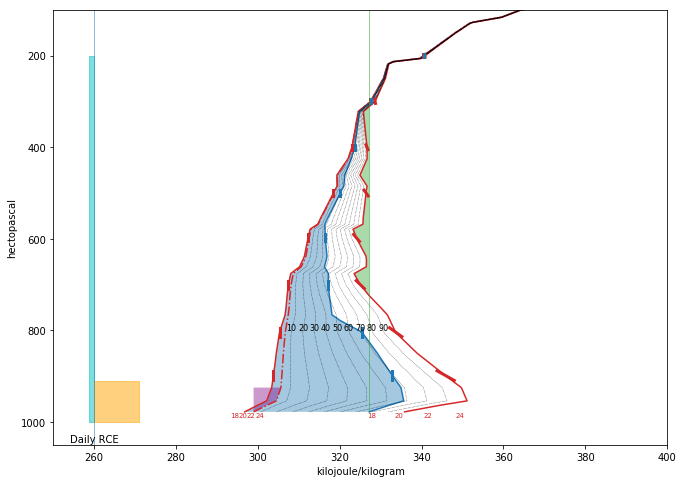

In [6]:
mep = MassEnergyPlot()

# Plot the sounding data
mep.ax.plot(s, pressure, color='tab:red', linewidth=1.5)
mep.ax.plot(sv, pressure, color='tab:red', linestyle='-.')
mep.ax.plot(h, pressure, color='tab:blue', linewidth=1.5)
mep.ax.plot(hs, pressure, color='tab:red', linewidth=1.5)

# Add annotations
mep.isohumes(pressure, s, qs)
mep.shade_precipitable_water(pressure, s, h)
mep.rce_reference()
mep.radiative_cooling_reference()
mep.surface_flux_reference()
mep.internal_waves(pressure, temperature)
mep.shade_cape(pressure, h, hs)
mep.shade_cin(pressure, temperature, dewpoint, sv)
mep.surface_water_values(pressure[0], heights[0], temperature[0], q[0])